In [1]:
#%matplotlib inline
%matplotlib notebook
import geopandas as gpd
from cartopy import crs as ccrs
import datetime as dt

import numpy as np
import pandas as pd
import requests
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm

from mpl_toolkits.axes_grid1 import make_axes_locatable

Gets the data from the Our World in Data dataset, and sets the date

In [2]:
full_data_address = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
res = requests.get(full_data_address)
full_data = pd.read_csv(StringIO(res.text), parse_dates = ['date'])
my_date = full_data["date"].max()

Creates the GeoPandas dataframe for the geographic information

In [18]:
path = gpd.datasets.get_path('naturalearth_lowres')
#path = r"E:\Data_repository\Geo\Shapefiles\ne_10m_admin_0_sovereignty\ne_10m_admin_0_sovereignty.shp"

gdf = gpd.read_file(path)

In [19]:
my_full_data = full_data[["date","total_deaths_per_million","iso_code","continent"]].set_index(["date","iso_code"])

my_tot_deaths_pm = my_full_data.groupby("iso_code").max().dropna()

Choices of latitude and longitude limits for the regions (not all regions covered yet)

In [20]:
region_lat = {
    "Europe": (33,73),
    "South America": (-60,20),
    "North America": (-5,100),
    "Americas": (-60,90)
}

region_long = {
    "Europe": (-13,42),
    "South America": (-90,-30),
    "North America": (-175,-45),
    "Americas": (-185,-25)
}

Sets:
- colormap
- region
- elevation parameter

In [24]:
cmap = cm.get_cmap('Oranges')
region = "Americas"
elevation = 4

Makes the plot.

The elevation effect is created with gradual translations of the map.

Presently this is done at the level of individual countries, in order to set a different color / color shading, but likely there are better ways (particularly, more efficient) to do it.

<IPython.core.display.Javascript object>


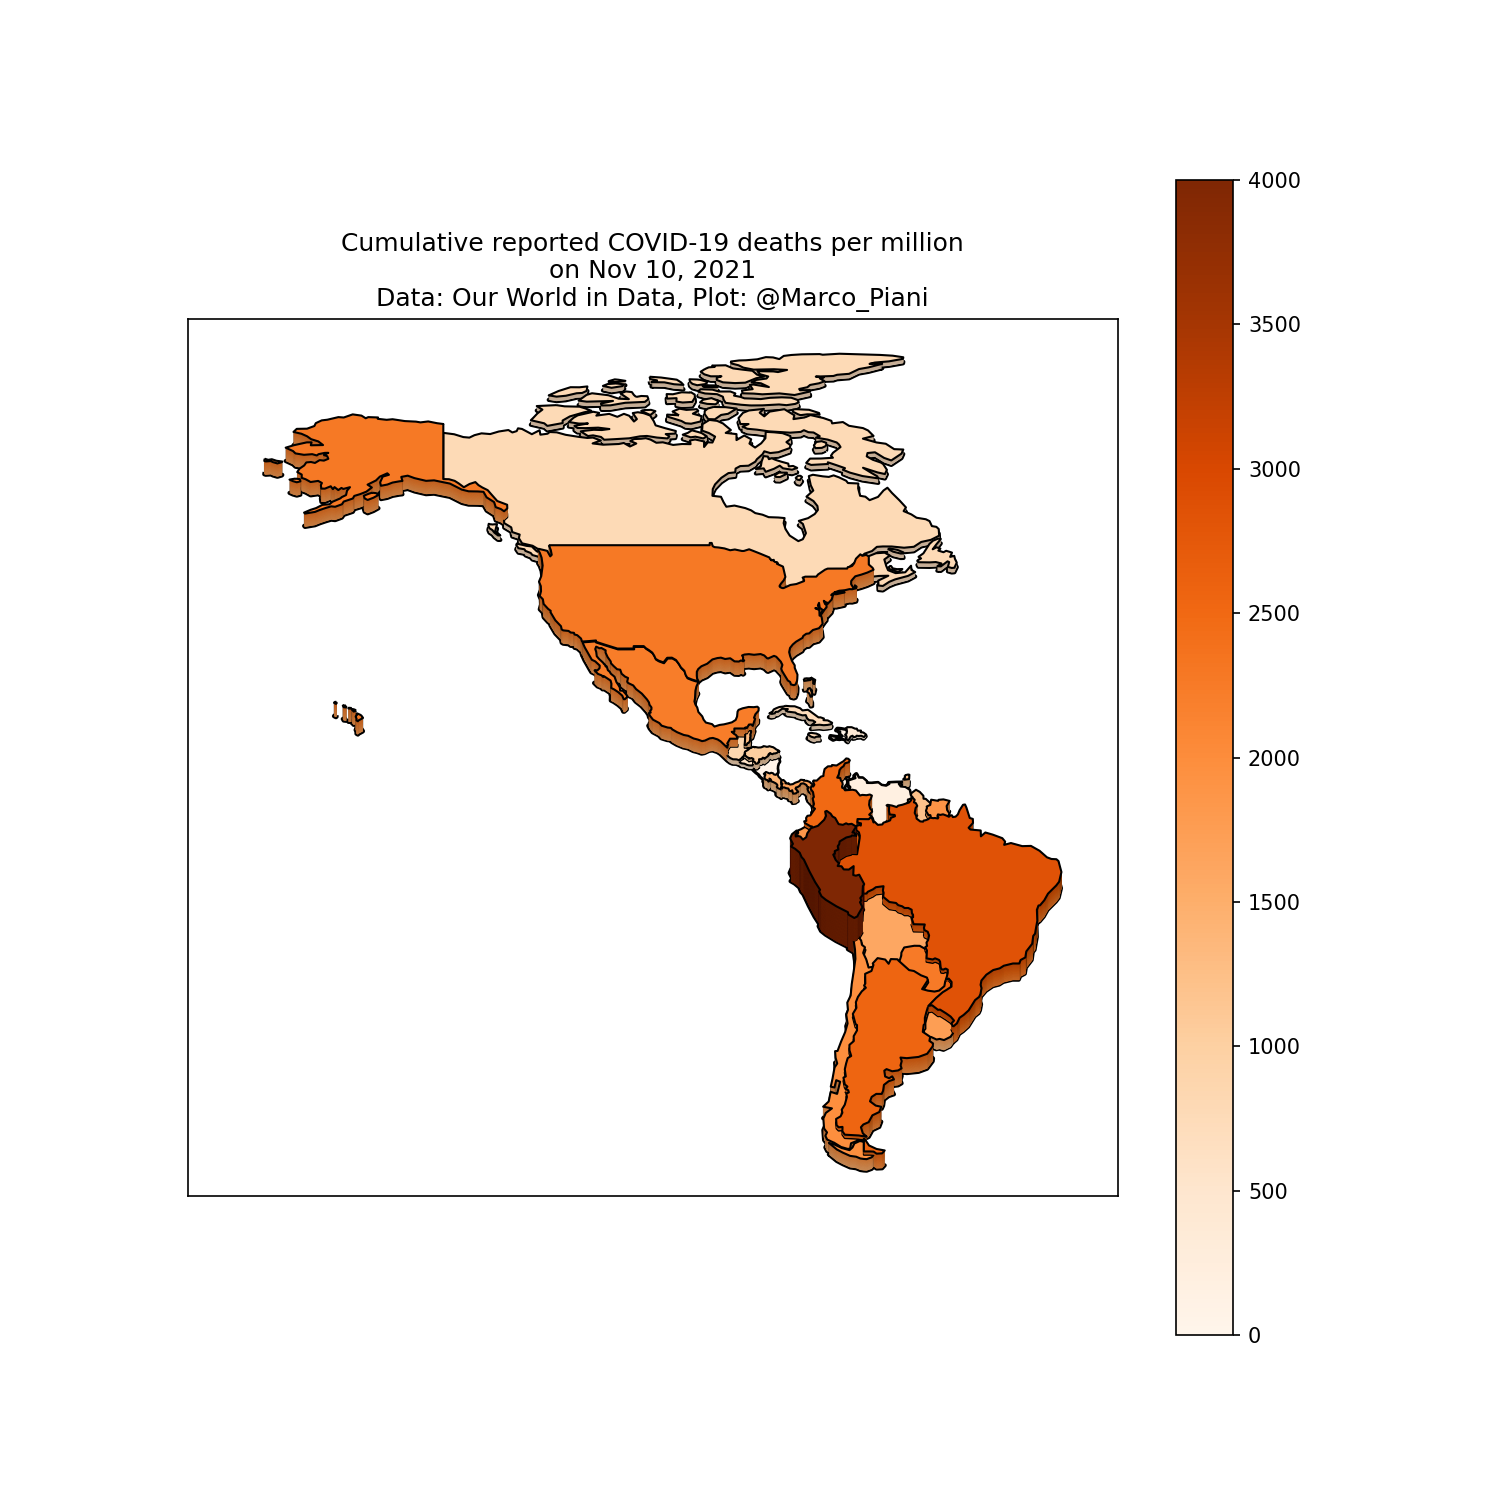

In [25]:
fig, ax = plt.subplots(figsize = (10,10), dpi = 150)

# Creates the color legend
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="3%", pad=0.01)

# Creates the GeoPandas dataframe with geographic information and relevant pandemic information combined
# setting the index to be the iso_a3 code
#my_gdf = gdf[["ADM0_A3_IS","geometry"]].set_index("ADM0_A3_IS")
my_gdf = gdf[["iso_a3","geometry"]].set_index("iso_a3")
my_gdf = my_gdf.join(my_tot_deaths_pm)

if region == "Americas":
    my_gdf = my_gdf[my_gdf.continent.isin(["North America","South America"])]
else:
    my_gdf = my_gdf[my_gdf.continent == region]

# sets the highest value represented
max_cmap = 4000#my_gdf["total_deaths_per_million"].max()

# plots a map to set the values for the color legend and create the base
mymap = my_gdf.plot("total_deaths_per_million",
    ax = ax, linewidth = 2, edgecolor = "black", cmap = "Oranges", vmin = 0, vmax = max_cmap, legend = True)
#    cax = cax)

# now that we have created the legend, we can normalize the deaths, to make the translation and the shading easier
my_gdf["total_deaths_per_million"]=( my_gdf["total_deaths_per_million"] / max_cmap )

# We have plotted the basic map with the actual range; we now iterate over the countries,
# creating single-country dataframes
for country, value in my_gdf["total_deaths_per_million"].items():
    #print(country)
    # single country GeoPandas df
    my_country_gdf = my_gdf[my_gdf.index == country]
    # Here we translate the single country at regular intervals, changing both the color and the zorder; the
    # semitransparent border adds to the effect of the "extrusion"
    for idx, delta_y in enumerate(np.arange(0,value,0.01)):
        my_country_gdf.translate(yoff = delta_y*elevation).plot(ax = ax,zorder = idx+1,
                color = cmap((delta_y+3*value)/4), # the color of a layer is set so to resemble the final color
                linewidth = 0.4,edgecolor = (0,0,0,0.1) # partially opaque black border
        )
    # Final country plot at the top of the country stack
    my_country_gdf.translate(yoff = value*elevation).plot(color=cmap(value),ax = ax,zorder = idx+2,
                                        edgecolor = "black", linewidth = 1)

# background gradient
# gradient = np.geomspace(region_long[region][0], region_long[region][1], 200).reshape(1, -1).T
# ax.imshow(gradient, cmap=cm.Blues_r,
#           extent=(region_long[region][0], region_long[region][1],region_lat[region][0], region_lat[region][1]),
#           alpha=1, zorder = -10, aspect = 'auto')

# setting the limits
ax.set_xlim(region_long[region])
ax.set_ylim(region_lat[region])
# removing the axes
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

#setting the title
ax.set_title(
    "Cumulative reported COVID-19 deaths per million\n"
    "on "+ my_date.strftime("%b %d, %Y") + "\nData: Our World in Data, Plot: @Marco_Piani")

fig.show()